## Connect to the workspace

In [1]:
from azureml.core import Workspace, Experiment

In [2]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: ubcdsedays
Azure region: eastus
Subscription id: f2e1f0df-51fd-491a-aa0f-49fcd6b5ff19
Resource group: ub-cdse


## Start tracking as an experiment
Experiment allows us to capture code, metrics and logs from a notebook run. In this example, we track the run as 'noteboo-run'. Subsequent runs will also be associated with the same experiment allowing us to manage different iterations of the experiment

In [3]:
experiment = Experiment(workspace=ws, name='notebook-run')
run = experiment.start_logging()

## Download data
We use the same data as the AutoML and Designer experiments. To keep the notebook simple, we select only the numeric features in this notebook

In [4]:
import pandas as pd
import numpy as np
import sklearn

#Automobile price dataset
URL='https://raw.githubusercontent.com/MicrosoftLearning/Principles-of-Machine-Learning-Python/master/Module7/Automobile%20price%20data%20_Raw_.csv'
FEATURES = [
        'length',
        'width',
        'height',
        'curb-weight',
        'compression-ratio',
        'horsepower',
        'peak-rpm',
        'city-mpg',
        'highway-mpg']
LABEL = 'price'

df = pd.read_csv(
    URL, 
    header=0, 
    usecols= FEATURES  + [LABEL],
    na_values='?',
    dtype=np.float32)
# convert to numeric
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 10 columns):
length               199 non-null float32
width                199 non-null float32
height               199 non-null float32
curb-weight          199 non-null float32
compression-ratio    199 non-null float32
horsepower           199 non-null float32
peak-rpm             199 non-null float32
city-mpg             199 non-null float32
highway-mpg          199 non-null float32
price                199 non-null float32
dtypes: float32(10)
memory usage: 9.3 KB


## Training
We use a Random Forest Regressor

In [5]:
import numpy
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES],df[LABEL], test_size=0.3)

In [7]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=10)
clf = clf.fit(X_train, y_train)

R2: 0.8905480181479016


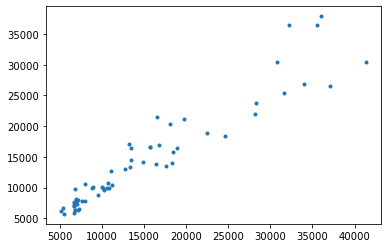

In [8]:
yhat = clf.predict(X_test)
plt.plot(y_test, yhat, '.')
r2 = r2_score(y_test, yhat)
print("R2:", r2)

## Logging
We log the metrics as part of the experiment run. This can be inspected at a later date



In [9]:
run.log(name="r2", value=r2)
run.complete()

## Saving the model

In [10]:
import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']

## Register model

In [11]:
from azureml.core import Model

In [12]:
from azureml.core import Dataset

np.savetxt('features.csv', X_train, delimiter=',')
np.savetxt('labels.csv', y_train, delimiter=',')
datastore = ws.get_default_datastore()
datastore.upload_files(files=['./features.csv', './labels.csv'],
                       target_path='sklearn_regression/',
                       overwrite=True)
input_dataset = Dataset.Tabular.from_delimited_files(path=[(datastore, 'sklearn_regression/features.csv')])
output_dataset = Dataset.Tabular.from_delimited_files(path=[(datastore, 'sklearn_regression/labels.csv')])

Uploading an estimated of 2 files
Uploading ./features.csv
Uploaded ./features.csv, 1 files out of an estimated total of 2
Uploading ./labels.csv
Uploaded ./labels.csv, 2 files out of an estimated total of 2
Uploaded 2 files


In [13]:
model = Model.register(
    workspace=ws, 
    model_name="model",
    model_path='model.pkl', 
    model_framework=Model.Framework.SCIKITLEARN,
    sample_input_dataset=input_dataset,
    sample_output_dataset=output_dataset)

Registering model model


## Deploying the model

In [14]:
service_name = 'sklearn-service'
service = Model.deploy(ws, service_name, [model], overwrite=True)
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-03-30 02:31:53+00:00 Registering the environment.
2021-03-30 02:31:56+00:00 Uploading autogenerated assets for no-code-deployment..
2021-03-30 02:32:00+00:00 Use the existing image.
2021-03-30 02:32:00+00:00 Generating deployment configuration.
2021-03-30 02:32:01+00:00 Submitting deployment to compute.
2021-03-30 02:32:03+00:00 Checking the status of deployment sklearn-service.